In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# load python functions and modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from astropy.io import fits
from shapely.geometry import Point
import shapely.affinity
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# set user directories
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
lvl1path = '/Volumes/miri_mrs_data/FM_MRS/'
lvl2path = workDir+'FM_data/LVL2/'
cdpDir   = workDir+'cdp_data/'

**Let's load the LVL1 data**

In [3]:
# Get data
sci_exp_hdu_SW   = fits.open(lvl1path+'FM1T00011453/MIRFM1T00011453_1_495_SE_2011-06-03T21h10m39.fits')
sci_exp_ramp_SW  = (sci_exp_hdu_SW[0].data).astype('float')

sci_exp_hdu_LW   = fits.open(lvl1path+'FM1T00011453/MIRFM1T00011453_1_494_SE_2011-06-03T21h10m20.fits')
sci_exp_ramp_LW  = (sci_exp_hdu_LW[0].data).astype('float')

# print spectral bands
print( 'MIRIFUSHORT:')
print( 'DGAA_pos = {}'.format(sci_exp_hdu_SW[0].header['DGAA_POS']))
print( 'DGAB_pos = {}'.format(sci_exp_hdu_SW[0].header['DGAB_POS']))
print( 'MIRIFULONG:')
print( 'DGAA_pos = {}'.format(sci_exp_hdu_LW[0].header['DGAA_POS']))
print( 'DGAB_pos = {}'.format(sci_exp_hdu_LW[0].header['DGAB_POS']))

# select data to use
sci_exp_hdu  = sci_exp_hdu_SW
sci_exp_ramp = sci_exp_ramp_SW

MIRIFUSHORT:
DGAA_pos = SHORT
DGAB_pos = SHORT
MIRIFULONG:
DGAA_pos = SHORT
DGAB_pos = SHORT


**HEADER INFORMATION**

In [4]:
print(repr(sci_exp_hdu[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1280                                                  
NAXIS3  =                   80 / length of third data axis                      
EXTEND  =                    T                                                  
                                                                                
                                                                                
                                                                                
DATE    = '2011-06-03T21:10:45' / date file created (yyyy-mm-ddThh:mm:ss,UTC)   
BSCALE  =                    1 / scale factor for array value to physical value 
BZERO   =                327

In [5]:
nints = sci_exp_hdu[0].header['NINT']
ngroups = sci_exp_hdu[0].header['NGROUP']
frame_delta_time = sci_exp_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('LVL1 data shape: {}'.format(sci_exp_ramp.shape))

Number of integrations: 2
Number of groups/frames per integration: 40
LVL1 data shape: (80, 1280, 1032)


**Plot MIRI ramp image**

<IPython.core.display.Javascript object>


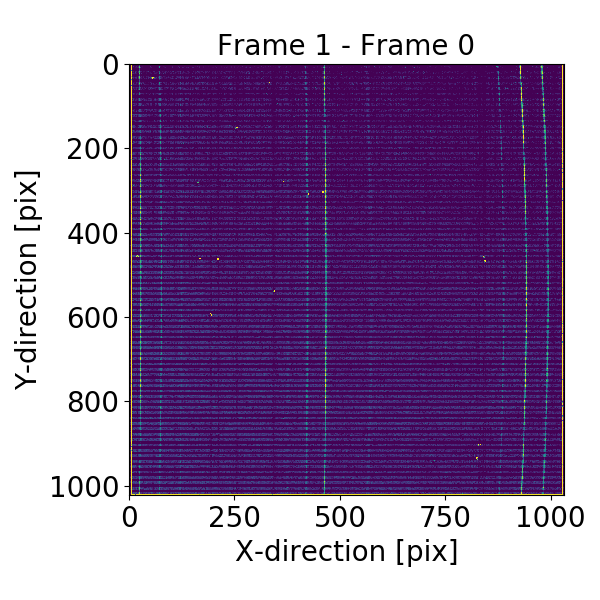

In [6]:
plt.figure(figsize=(6,6))
plt.title('Frame 1 - Frame 0')
plt.imshow(sci_exp_ramp[1,:1024,:]-sci_exp_ramp[0,:1024,:],vmin=0,vmax=100)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

**Let's look at the integration ramps for one pixel**

<IPython.core.display.Javascript object>


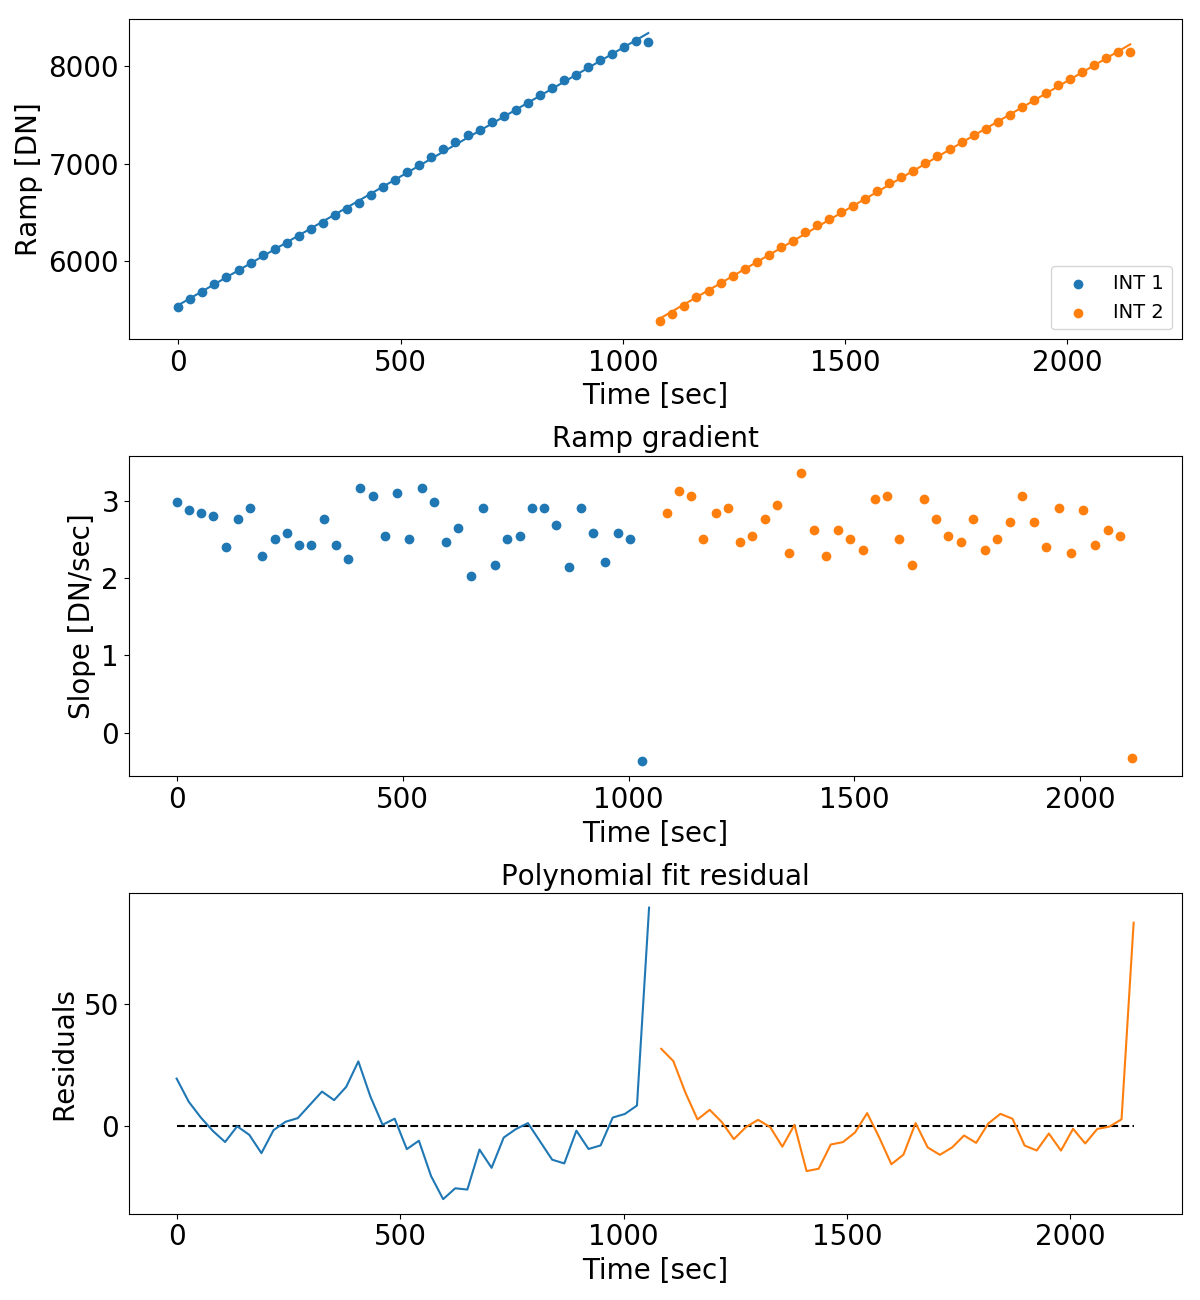

Determined slopes per integration: [2.64, 2.66] DN/sec
Determined slopes per integration (excluding last frame): [2.65, 2.67] DN/sec


In [7]:
ypos,xpos = 40,25
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes,slopes_minus_last_frame = [],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos]
    n_poly = 1
    
    popt = np.polyfit(xdata,ydata,n_poly)
    popt_minus_last_frame = np.polyfit(xdata[:-1],ydata[:-1],n_poly)
    poly = np.poly1d(popt)
    
    slopes.append(round(popt[0],2))
    slopes_minus_last_frame.append(round(popt_minus_last_frame[0],2))
    
    residuals = poly(xdata)-ydata

    axs[0].plot(xdata,poly(xdata))
    axs[0].scatter(xdata,ydata,label='INT {}'.format(i+1))
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[0].legend(loc='lower right')
    axs[1].set_title('Ramp gradient')
    axs[1].scatter(xdata[:-1],np.diff(ydata)/frame_delta_time)
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals)
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration: {} DN/sec'.format(slopes))
print ('Determined slopes per integration (excluding last frame): {} DN/sec'.format(slopes_minus_last_frame))

**Let's correct for the reset-switch-charge-decay (dummy correction)**

In [8]:
rscdCorrection = fits.open(cdpDir+'MIRI_FM_MIRIFUSHORT_12_RSCD_06.00.00.fits')[1].data
print('RSCD parameters: \n{}'.format(rscdCorrection))

tau = rscdCorrection[0][3]   # e-folding time scale (in units of seconds)
scale_factor = rscdCorrection[0][4]

sci_exp_ramp   = sci_exp_ramp[:,:1024,:] # ommit non-sensitive pixels
sci_exp_ramp_rscdCorr = np.full(sci_exp_ramp.shape,0.)
sci_exp_ramp_rscdCorr[:ngroups,:,:] = sci_exp_ramp[:ngroups,:,:]
for i in range(1,nints):
    # time since the last frame in the previous integration (units seconds)
    T = (np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time-np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups][0]*frame_delta_time)+frame_delta_time
    # data of previous integration
    ydata_previousINT  = sci_exp_ramp[(i-1)*ngroups:i*ngroups,ypos,xpos]
    # accumulated DNs over previous integration
    DN_accumulated = ydata_previousINT[-1]-ydata_previousINT[0]
    
    # apply correction
    timeMap = np.full(sci_exp_ramp_rscdCorr[i*ngroups:(i+1)*ngroups,:,:].shape,0.)
    for j in range(len(T)):
        timeMap[j,:,:] = T[j]
    sci_exp_ramp_rscdCorr[i*ngroups:(i+1)*ngroups,:,:] = sci_exp_ramp[i*ngroups:(i+1)*ngroups,:,:] + DN_accumulated * scale_factor * np.exp(-timeMap/tau)

RSCD parameters: 
[('FULL', 'SLOW', 'EVEN', 1.55, 0.050000001, 0.0, 0.0)
 ('FULL', 'SLOW', 'ODD', 1.55, 0.050000001, 0.0, 0.0)
 ('FULL', 'FAST', 'EVEN', 1.55, 0.050000001, 0.0, 0.0)
 ('FULL', 'FAST', 'ODD', 1.55, 0.050000001, 0.0, 0.0)]


**Let's correct for the non-linearity**

In [9]:
linearityCorrection = fits.open(cdpDir+'MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00.fits')[1].data

sci_exp_ramp_linCorr = np.full(sci_exp_ramp.shape,0.)
for i in range(sci_exp_ramp.shape[0]):
    sci_exp_ramp_linCorr[i,:,:] += linearityCorrection[0,:,:]+\
                                    linearityCorrection[1,:,:]*sci_exp_ramp_rscdCorr[i,:,:]+\
                                    linearityCorrection[2,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**2+\
                                    linearityCorrection[3,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**3+\
                                    linearityCorrection[4,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**4

print('Linearity correction factors for pixel ({},{}): \n Bias: {} \n Linear term: {} \n Quadratic term: {} \n 3rd order term: {} \n 4th order term: {}'.format(ypos,xpos,linearityCorrection[0,ypos,xpos],linearityCorrection[1,ypos,xpos],linearityCorrection[2,ypos,xpos],linearityCorrection[3,ypos,xpos],linearityCorrection[4,ypos,xpos]))

Linearity correction factors for pixel (40,25): 
 Bias: 0.0 
 Linear term: 0.889963984489 
 Quadratic term: 3.13666009788e-06 
 3rd order term: -2.32092331465e-11 
 4th order term: 3.93347489387e-16


<IPython.core.display.Javascript object>


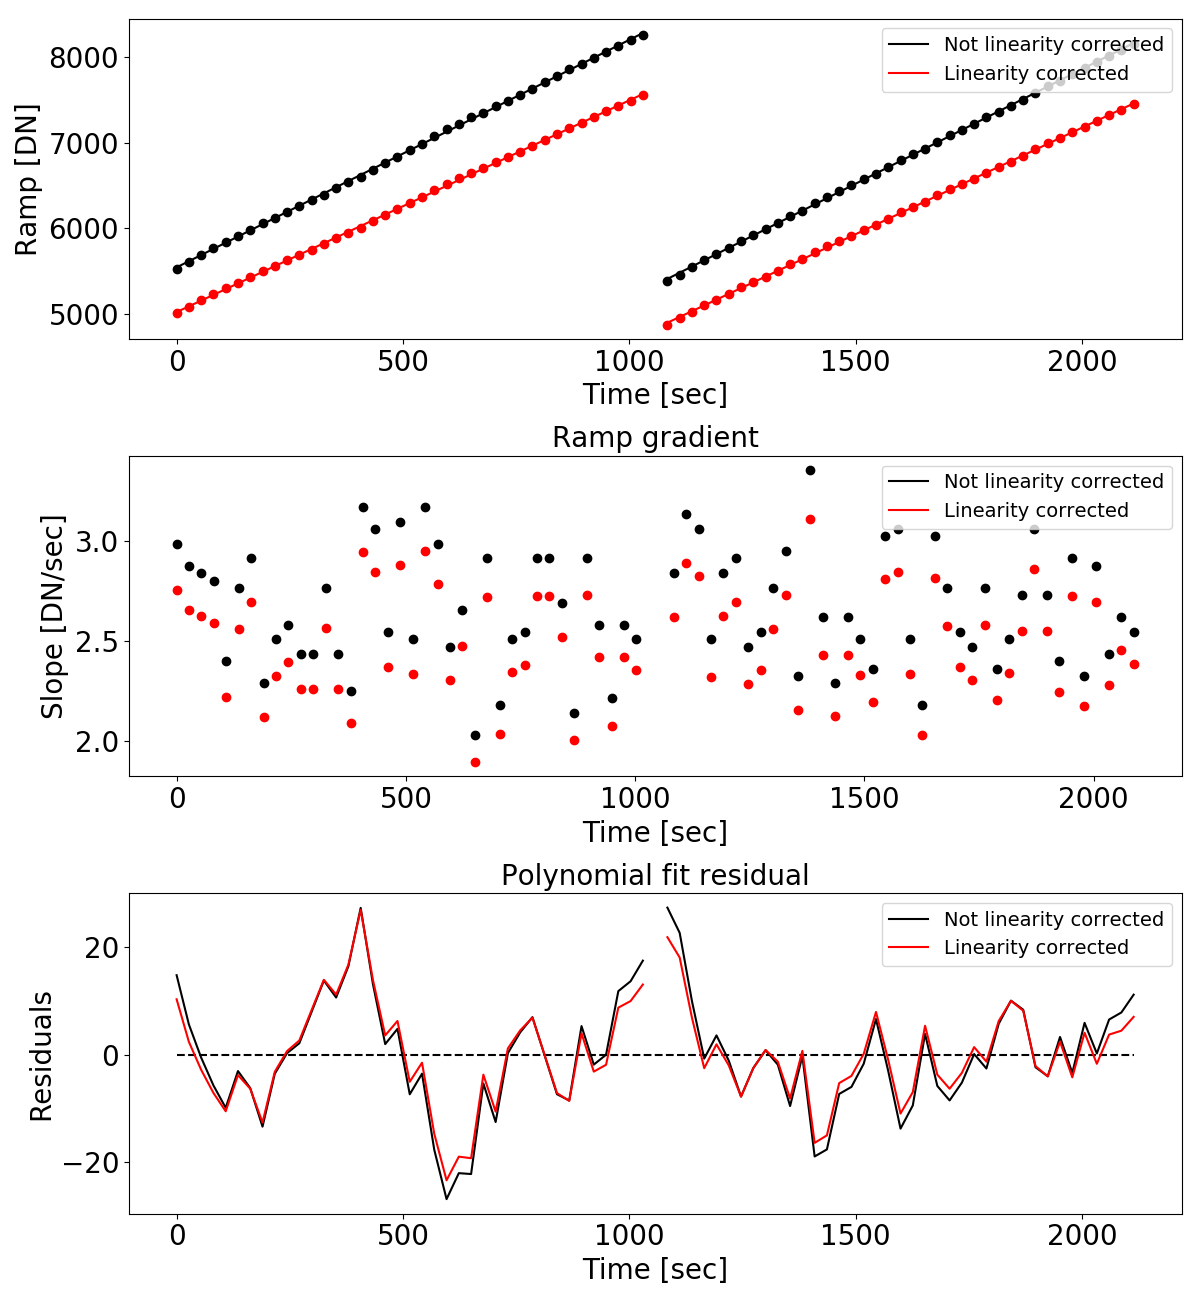

Determined slopes per integration (non-linearity uncorrected): [2.65, 2.67] DN/sec
Determined slopes per integration (non-linearity corrected): [2.47, 2.48] DN/sec


In [10]:
ypos,xpos = 40,25
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes_noLinCorr,slopes_LinCorr,slopes_noLinCorr_minus_last_frame,slopes_LinCorr_minus_last_frame = [],[],[],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups][:-1]*frame_delta_time
    ydata_noLinCorr  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    ydata_LinCorr    = sci_exp_ramp_linCorr[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    
    n_poly = 1
    popt_noLinCorr = np.polyfit(xdata,ydata_noLinCorr,n_poly)
    popt_noLinCorr_minus_last_frame = np.polyfit(xdata[:-1],ydata_noLinCorr[:-1],n_poly)
    poly_noLinCorr = np.poly1d(popt_noLinCorr)
    
    popt_LinCorr = np.polyfit(xdata,ydata_LinCorr,n_poly)
    popt_LinCorr_minus_last_frame = np.polyfit(xdata[:-1],ydata_LinCorr[:-1],n_poly)
    poly_LinCorr = np.poly1d(popt_LinCorr)
    
    slopes_noLinCorr.append(round(popt_noLinCorr[0],2))
    slopes_LinCorr.append(round(popt_LinCorr[0],2))
    slopes_noLinCorr_minus_last_frame.append(round(popt_noLinCorr_minus_last_frame[0],2))
    slopes_LinCorr_minus_last_frame.append(round(popt_LinCorr_minus_last_frame[0],2))
    
    residuals_noLinCorr = poly_noLinCorr(xdata)-ydata_noLinCorr
    residuals_LinCorr   = poly_LinCorr(xdata)-ydata_LinCorr

    axs[0].plot(xdata,poly_noLinCorr(xdata),'k')
    axs[0].plot(xdata,poly_LinCorr(xdata),'r')
    axs[0].plot(xdata,ydata_noLinCorr,'ko')
    axs[0].plot(xdata,ydata_LinCorr,'ro')
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[1].set_title('Ramp gradient')
    axs[1].plot(xdata[:-1],np.diff(ydata_noLinCorr)/frame_delta_time,'ko')
    axs[1].plot(xdata[:-1],np.diff(ydata_LinCorr)/frame_delta_time,'ro')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals_noLinCorr,'k')
    axs[2].plot(xdata,residuals_LinCorr,'r')
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
legend_elements = [Line2D([0],[0],color='k',label='Not linearity corrected'),
                   Line2D([0],[0],color='r',label='Linearity corrected')]
for plot in range(3): axs[plot].legend(handles=legend_elements,loc='upper right')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration (non-linearity uncorrected): {} DN/sec'.format(slopes_noLinCorr))
print ('Determined slopes per integration (non-linearity corrected): {} DN/sec'.format(slopes_LinCorr))

**Load LVL2 data**

In [3]:
# Get data
sci_exp_slope_hdu_SW = fits.open(lvl2path+'FM1T00011453/MIRFM1T00011453_1_495_SE_2011-06-03T21h10m39_LVL2.fits')
sci_exp_slope_SW = sci_exp_slope_hdu_SW[0].data[0,:,:]
sci_exp_slope_hdu_LW = fits.open(lvl2path+'FM1T00011453/MIRFM1T00011453_1_494_SE_2011-06-03T21h10m20_LVL2.fits')
sci_exp_slope_LW = sci_exp_slope_hdu_LW[0].data[0,:,:]

# select data to use
sci_exp_slope_hdu = sci_exp_slope_hdu_SW
sci_exp_slope     = sci_exp_slope_SW

**Plot slope image (average slope, from all integration ramps)**

<IPython.core.display.Javascript object>


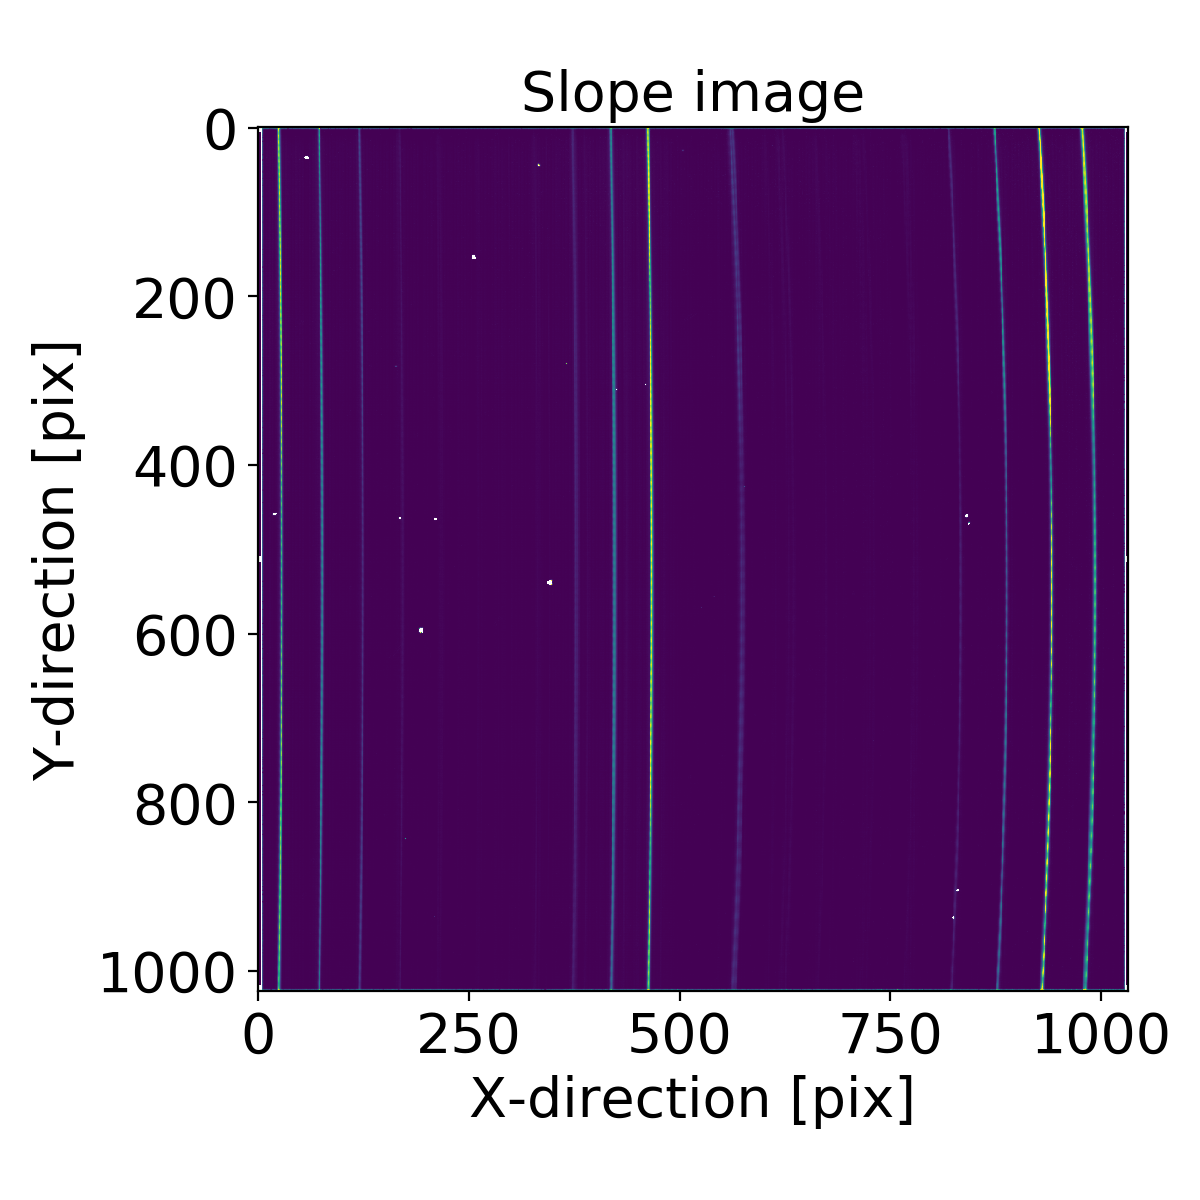

In [4]:
plt.figure(figsize=(6,6))
plt.title('Slope image')
plt.imshow(sci_exp_slope,vmin=0,vmax=3)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

**Load distortion maps**

In [5]:
d2cMaps = d2cMapping('1A',cdpDir+'CDP7/',fileversion='7B.05.01')

alphaMap  = d2cMaps['alphaMap']
betaMap   = d2cMaps['betaMap']
lambdaMap = d2cMaps['lambdaMap']
sliceMap  = d2cMaps['sliceMap']
nslices   = d2cMaps['nslices']

<IPython.core.display.Javascript object>


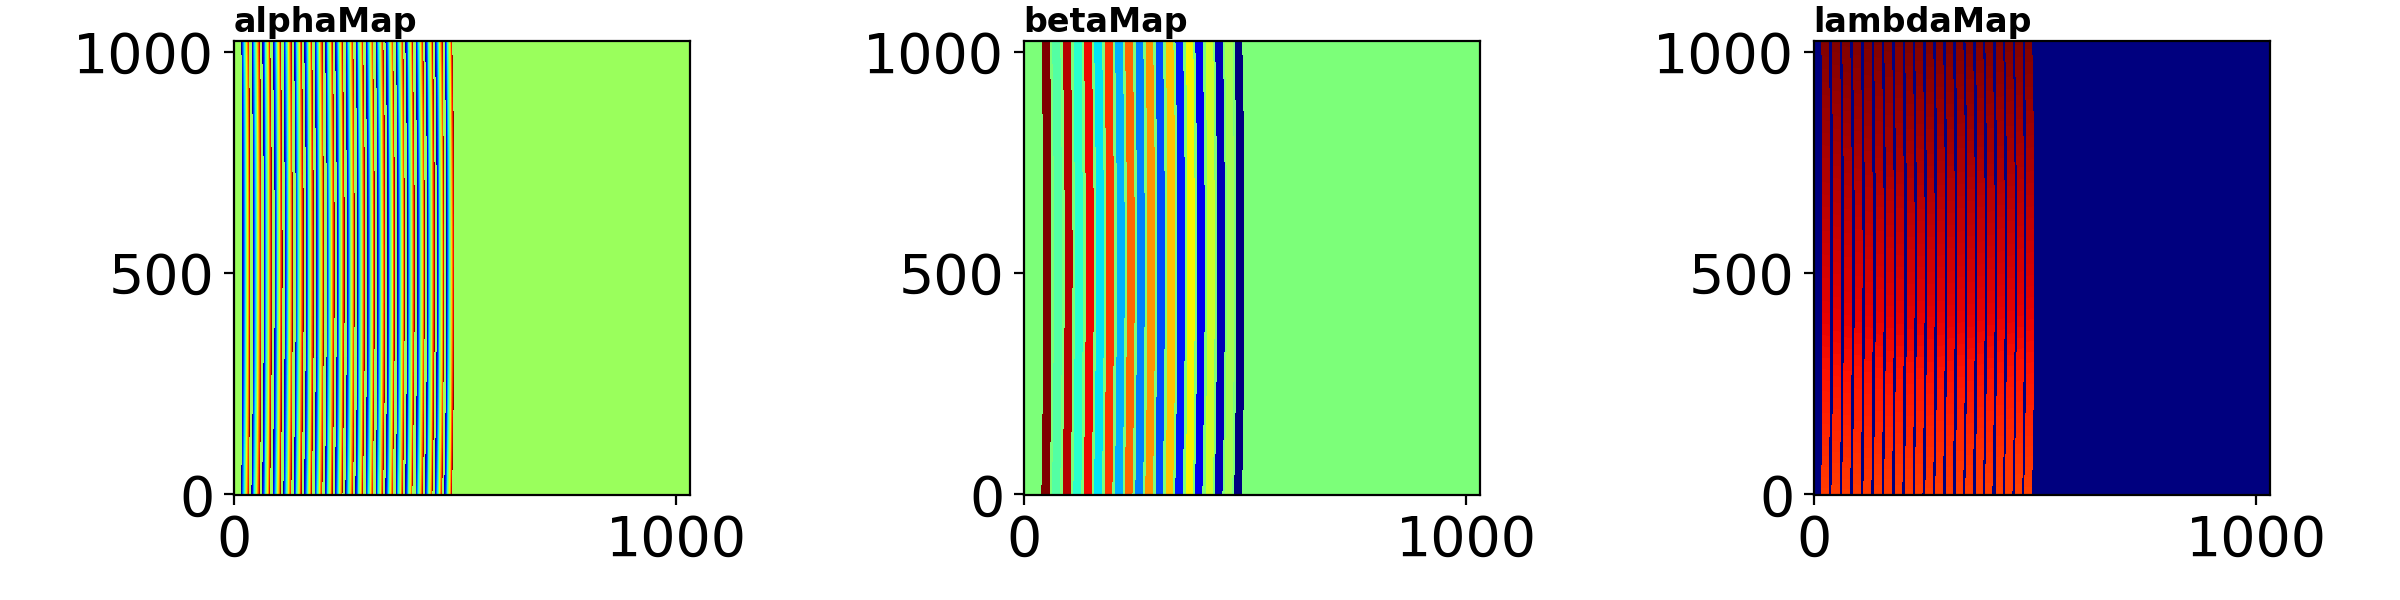

<IPython.core.display.Javascript object>


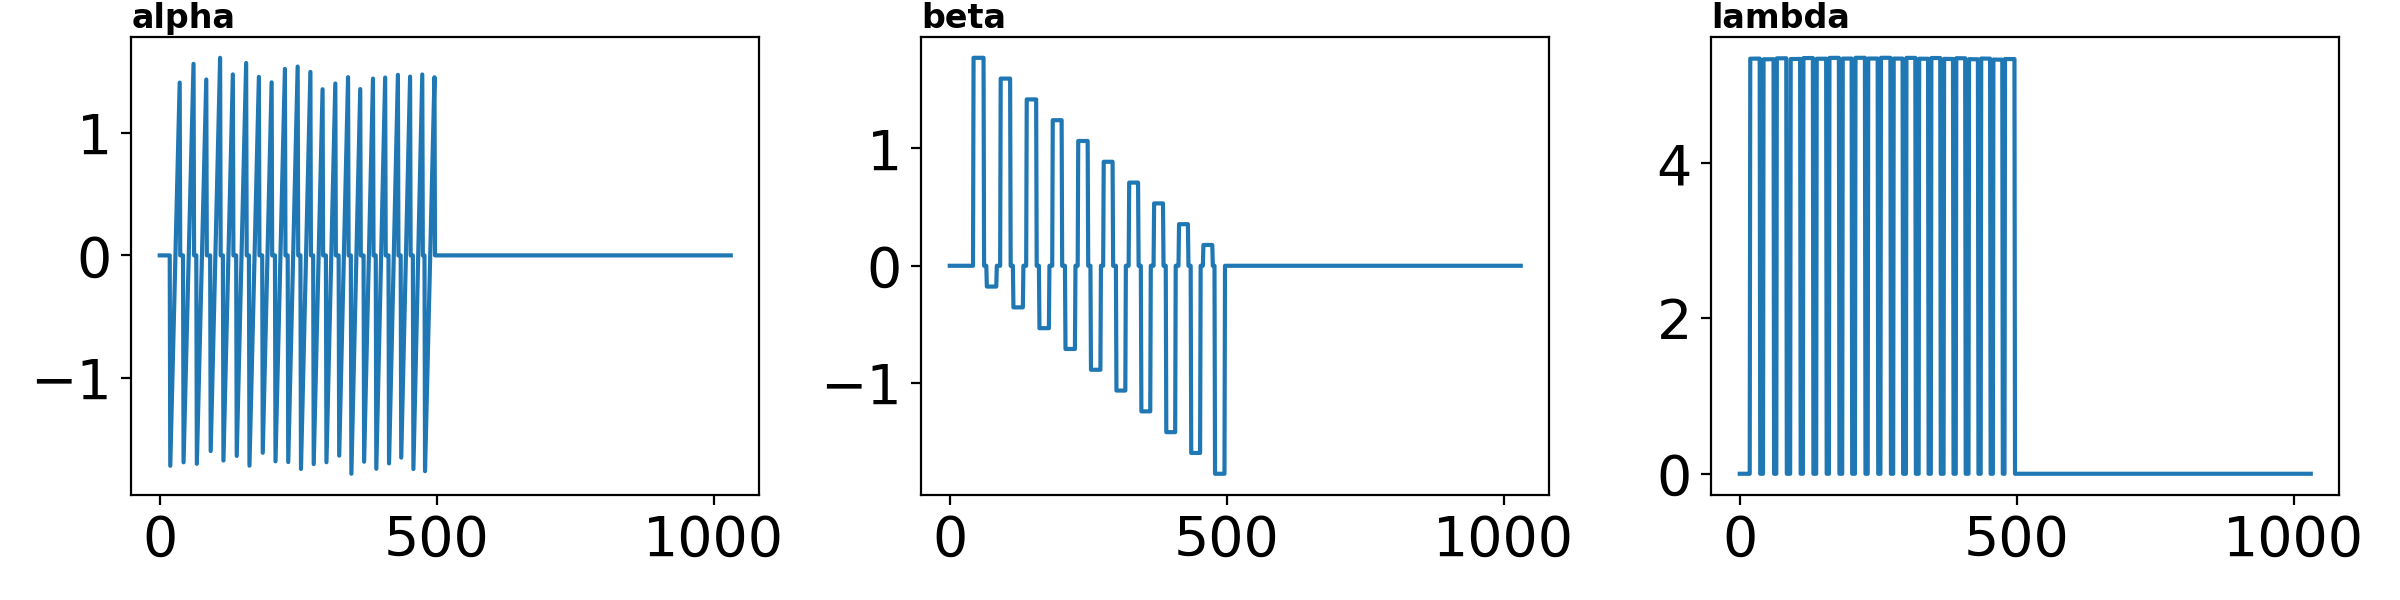

In [6]:
fig,axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(alphaMap,cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('alphaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(betaMap,cmap='jet', interpolation='nearest', origin='lower')
axs[1].annotate('betaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(lambdaMap,cmap='jet', interpolation='nearest', origin='lower')
axs[2].annotate('lambdaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()
plt.show()

row = 512
fig,axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(alphaMap[row,:])
axs[0].annotate('alpha', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].plot(betaMap[row,:])
axs[1].annotate('beta', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].plot(lambdaMap[row,:])
axs[2].annotate('lambda', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()
plt.show()

**Let's plot the signal in a pixel trace (row/column) on the detector**

<IPython.core.display.Javascript object>


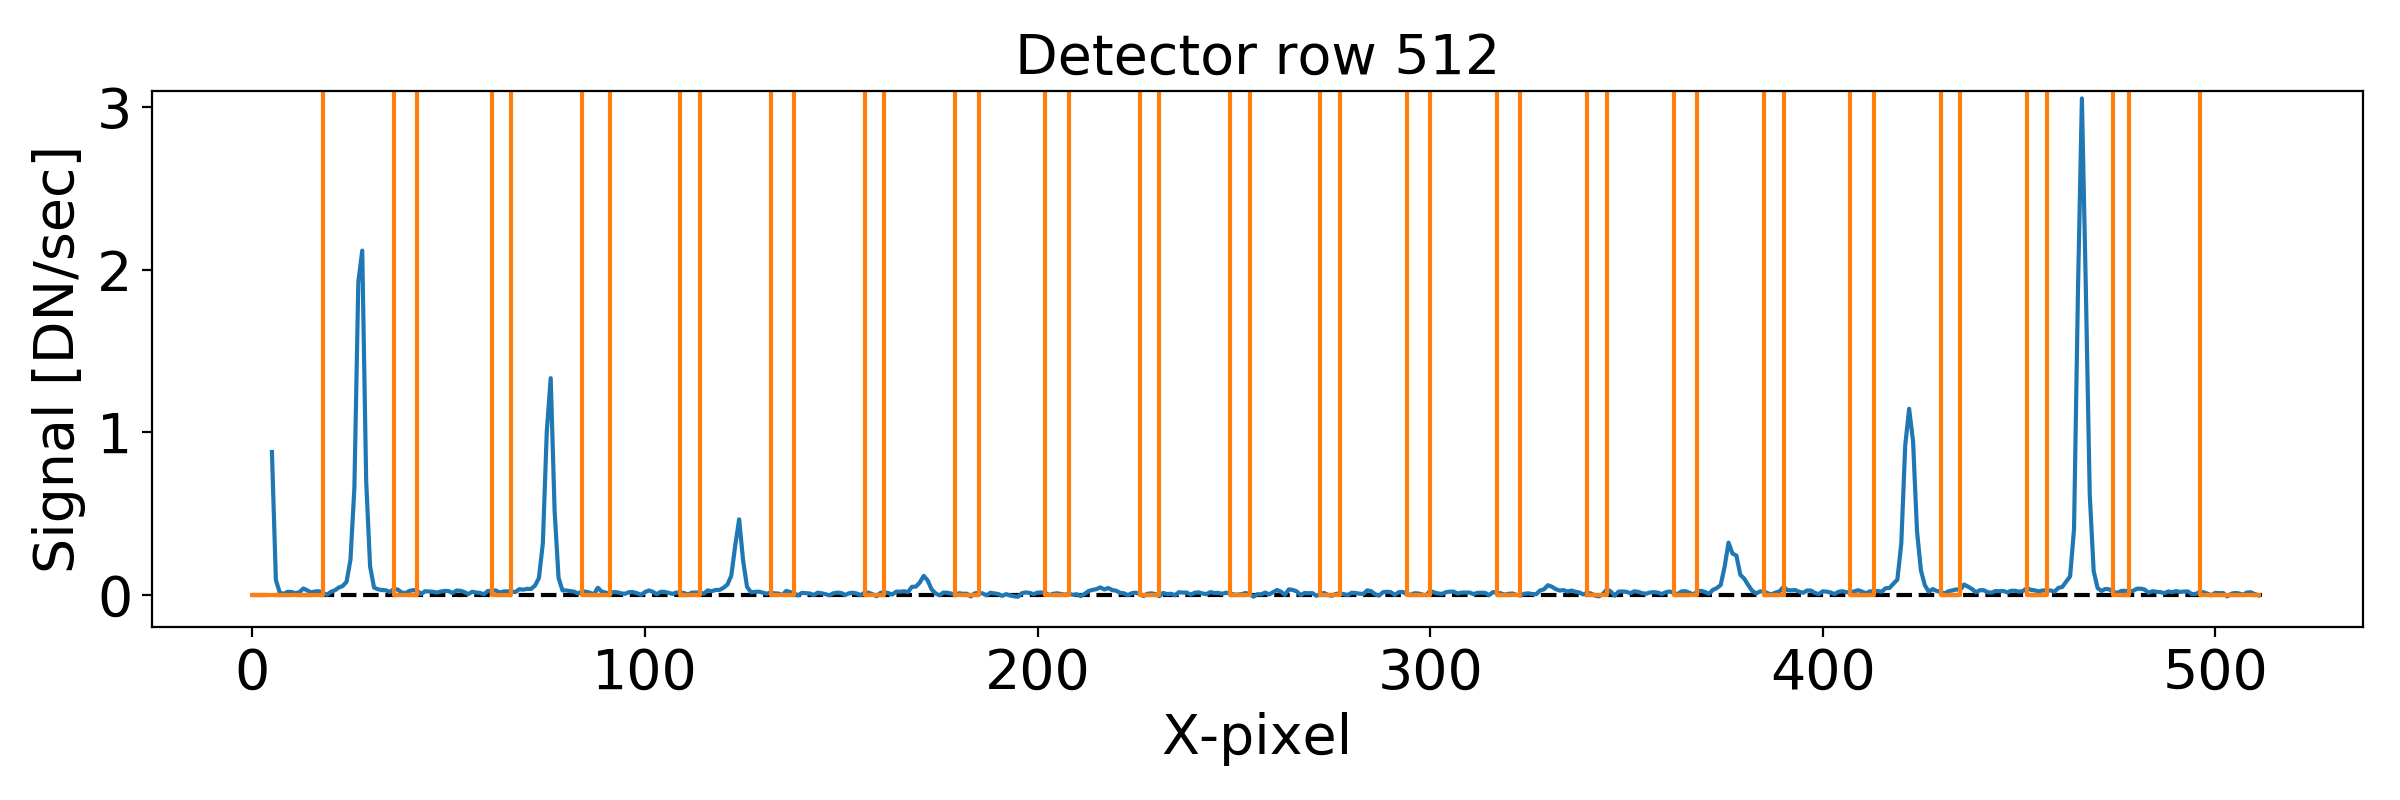

<IPython.core.display.Javascript object>


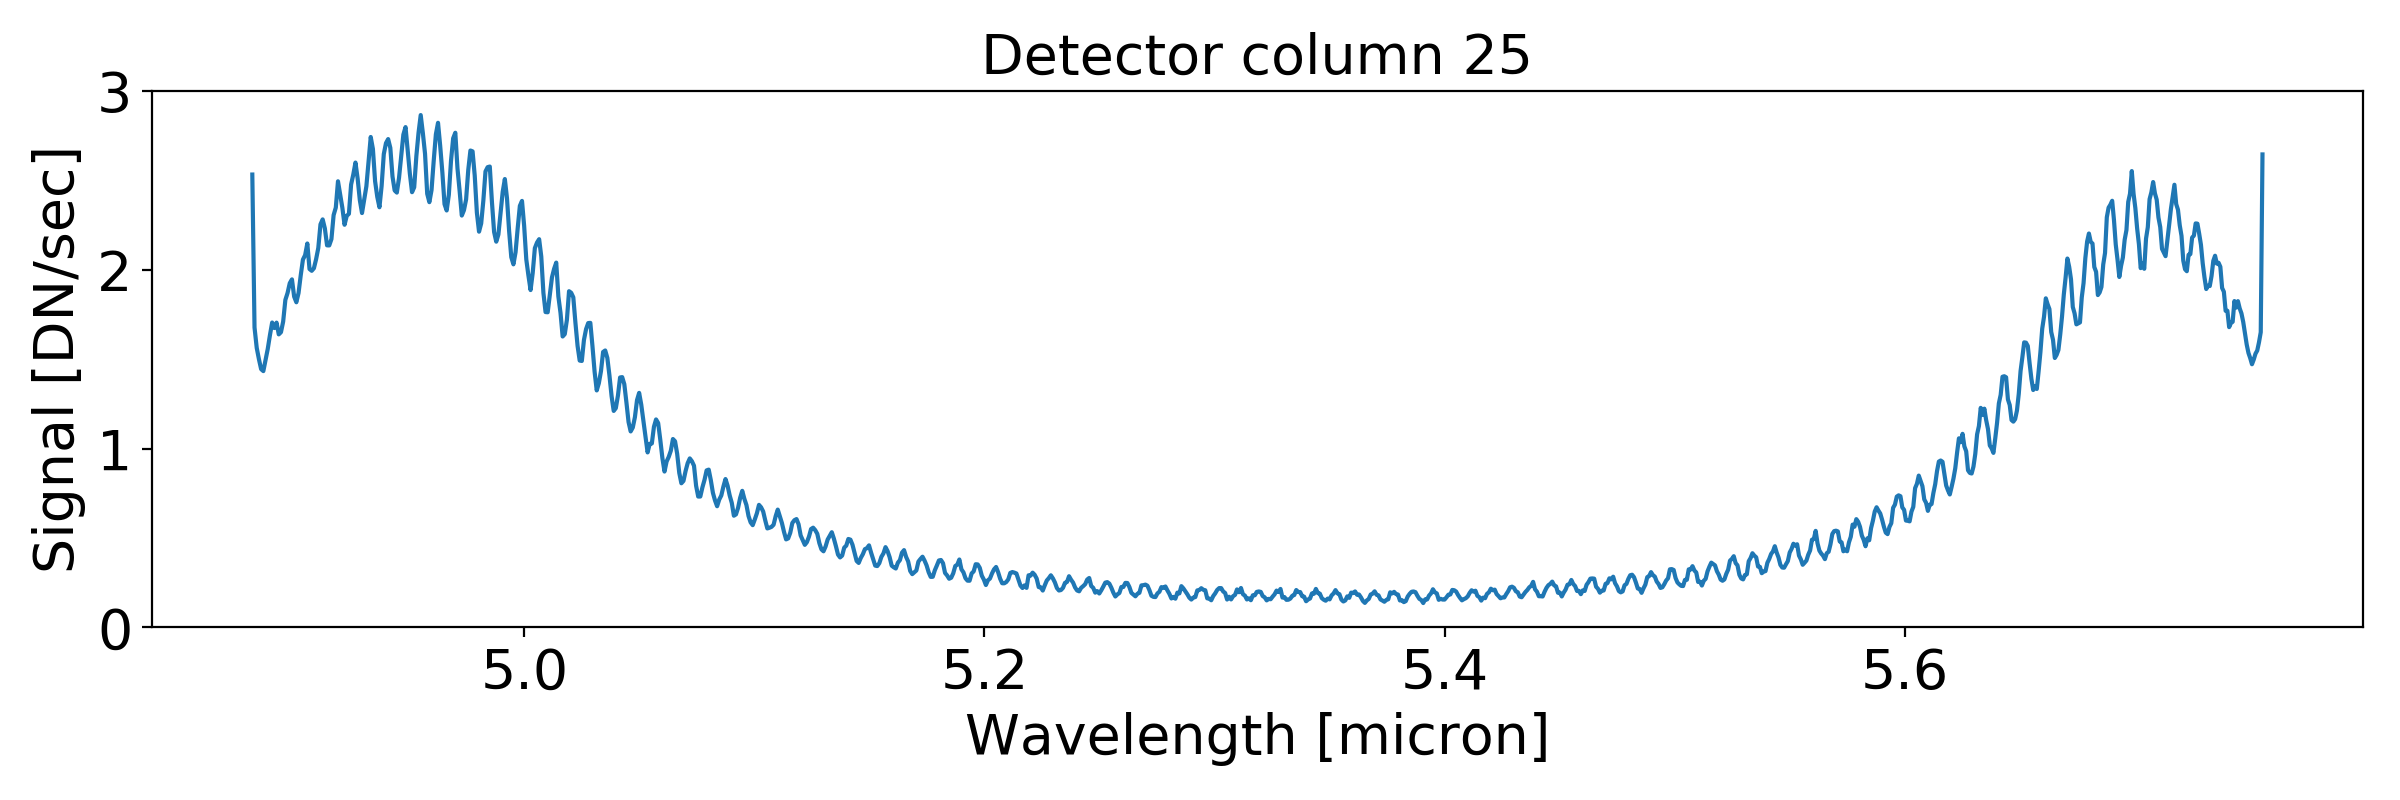

In [7]:
yrow = 512
plt.figure(figsize=(12,4))
plt.title('Detector row {}'.format(yrow))
plt.plot(sci_exp_slope[yrow,:512])
plt.step(np.arange(512),sliceMap[yrow,:512])
plt.hlines(0,0,512,'k',linestyle='dashed')
plt.ylim(-0.2,3.1)
plt.xlabel('X-pixel')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

xcol = 25
plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope[:,xcol])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

**Apply fringe correction**

<IPython.core.display.Javascript object>


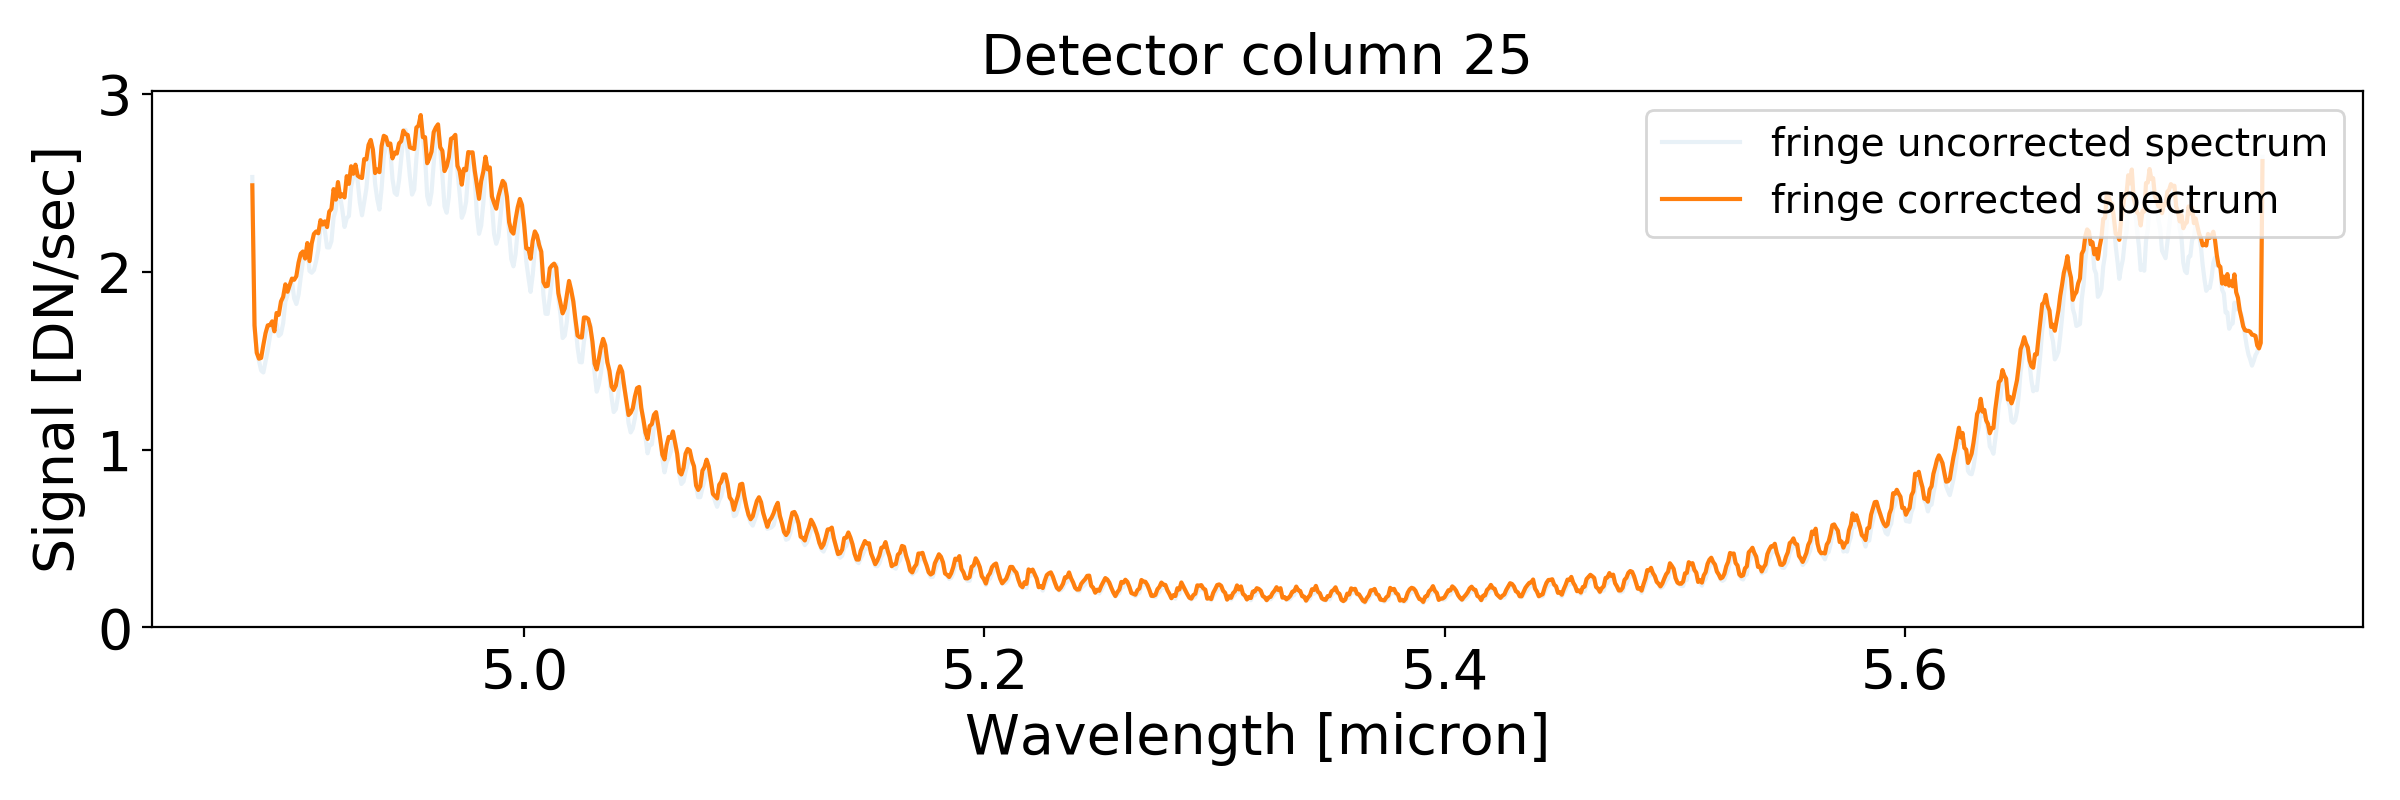

<IPython.core.display.Javascript object>


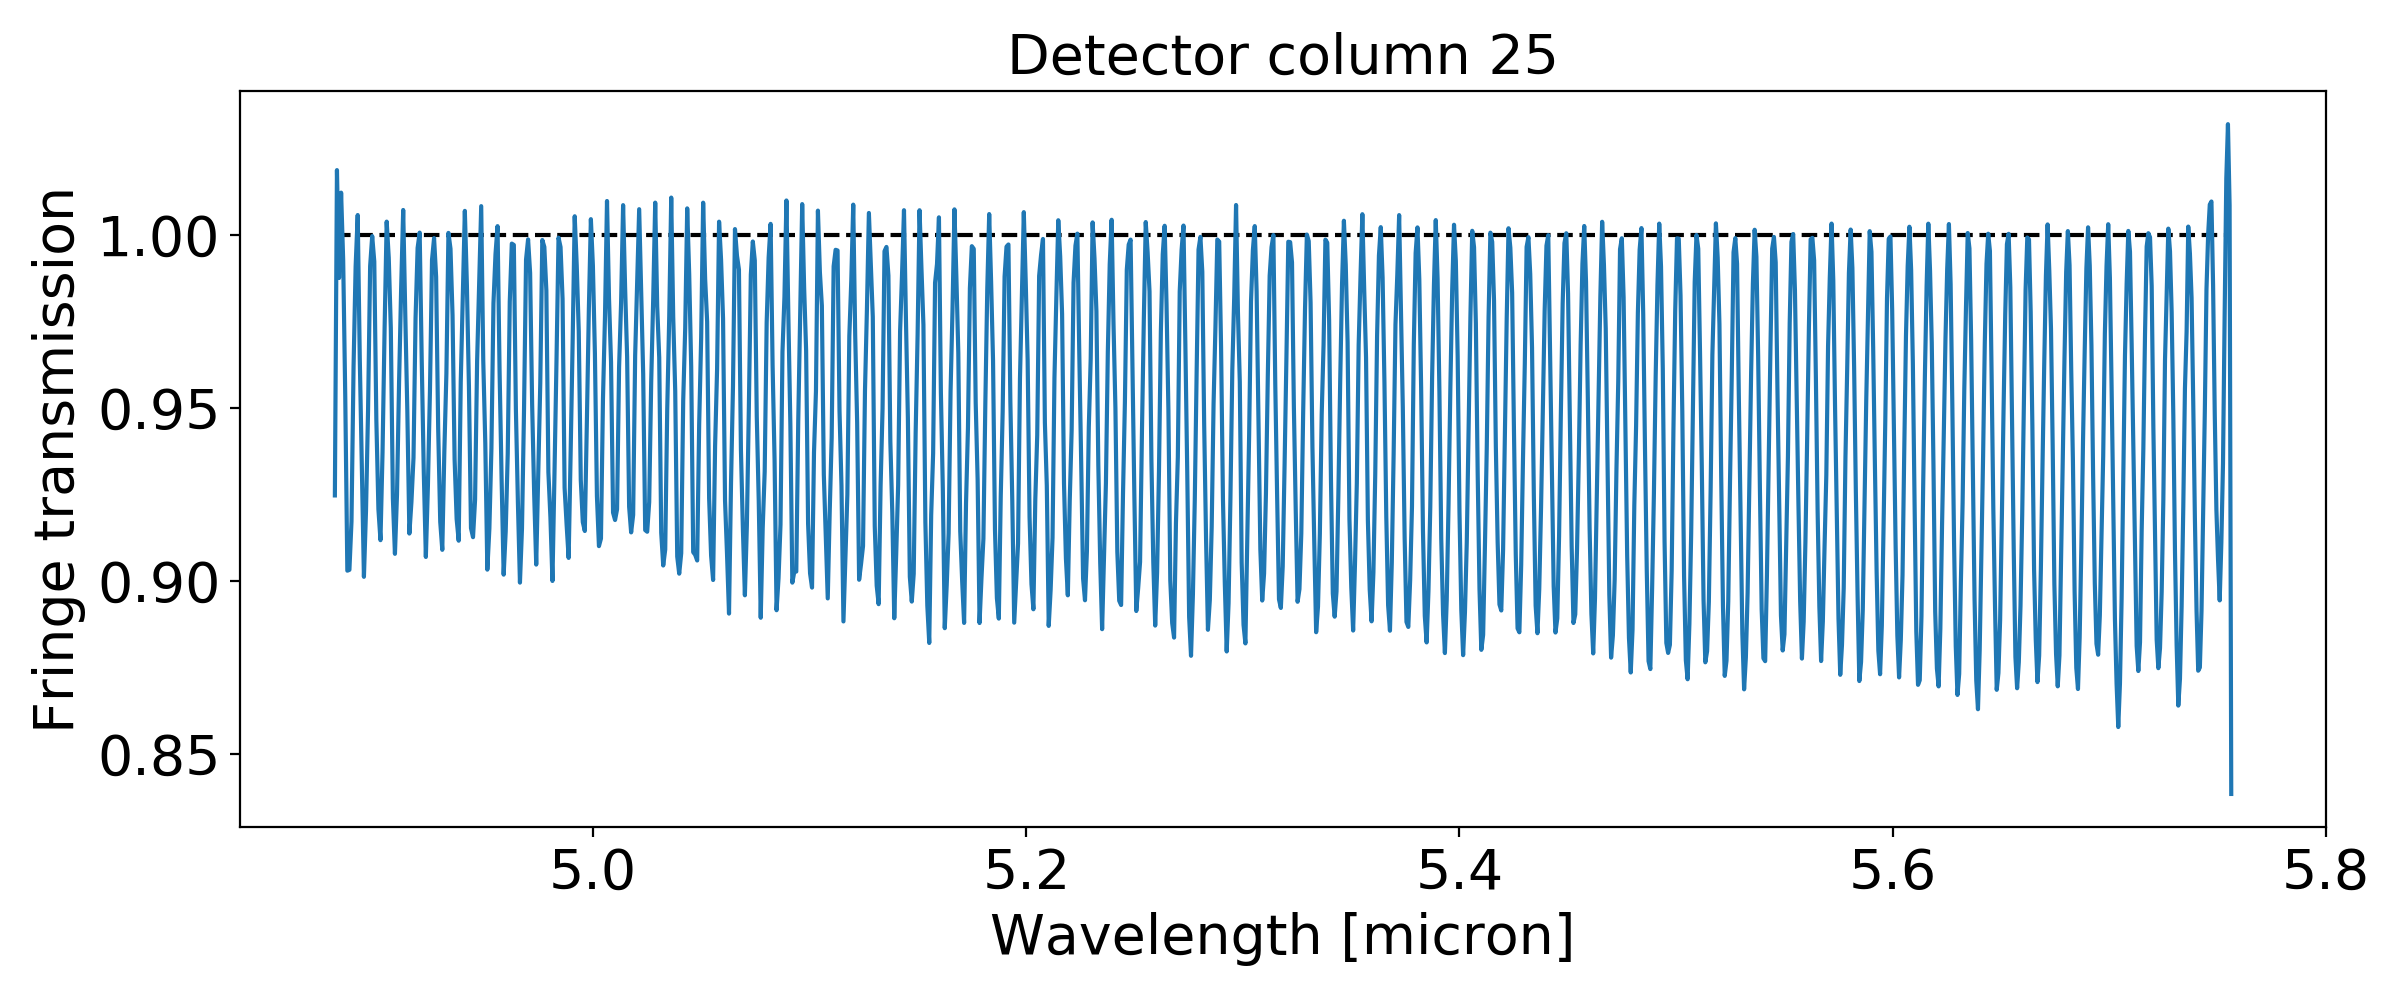

In [8]:
fringe_img = funcs.get_cdps('1A',cdpDir)[0]
sci_exp_slope_fringeCorr = sci_exp_slope/fringe_img

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope[:,xcol],alpha=0.1,label='fringe uncorrected spectrum')
plt.plot(lambdaMap[:,xcol],sci_exp_slope_fringeCorr[:,xcol],label='fringe corrected spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],fringe_img[:,xcol])
plt.hlines(1,lambdaMap[:,xcol][0],lambdaMap[:,xcol][-1],'k',linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Fringe transmission')
plt.tight_layout()

<IPython.core.display.Javascript object>


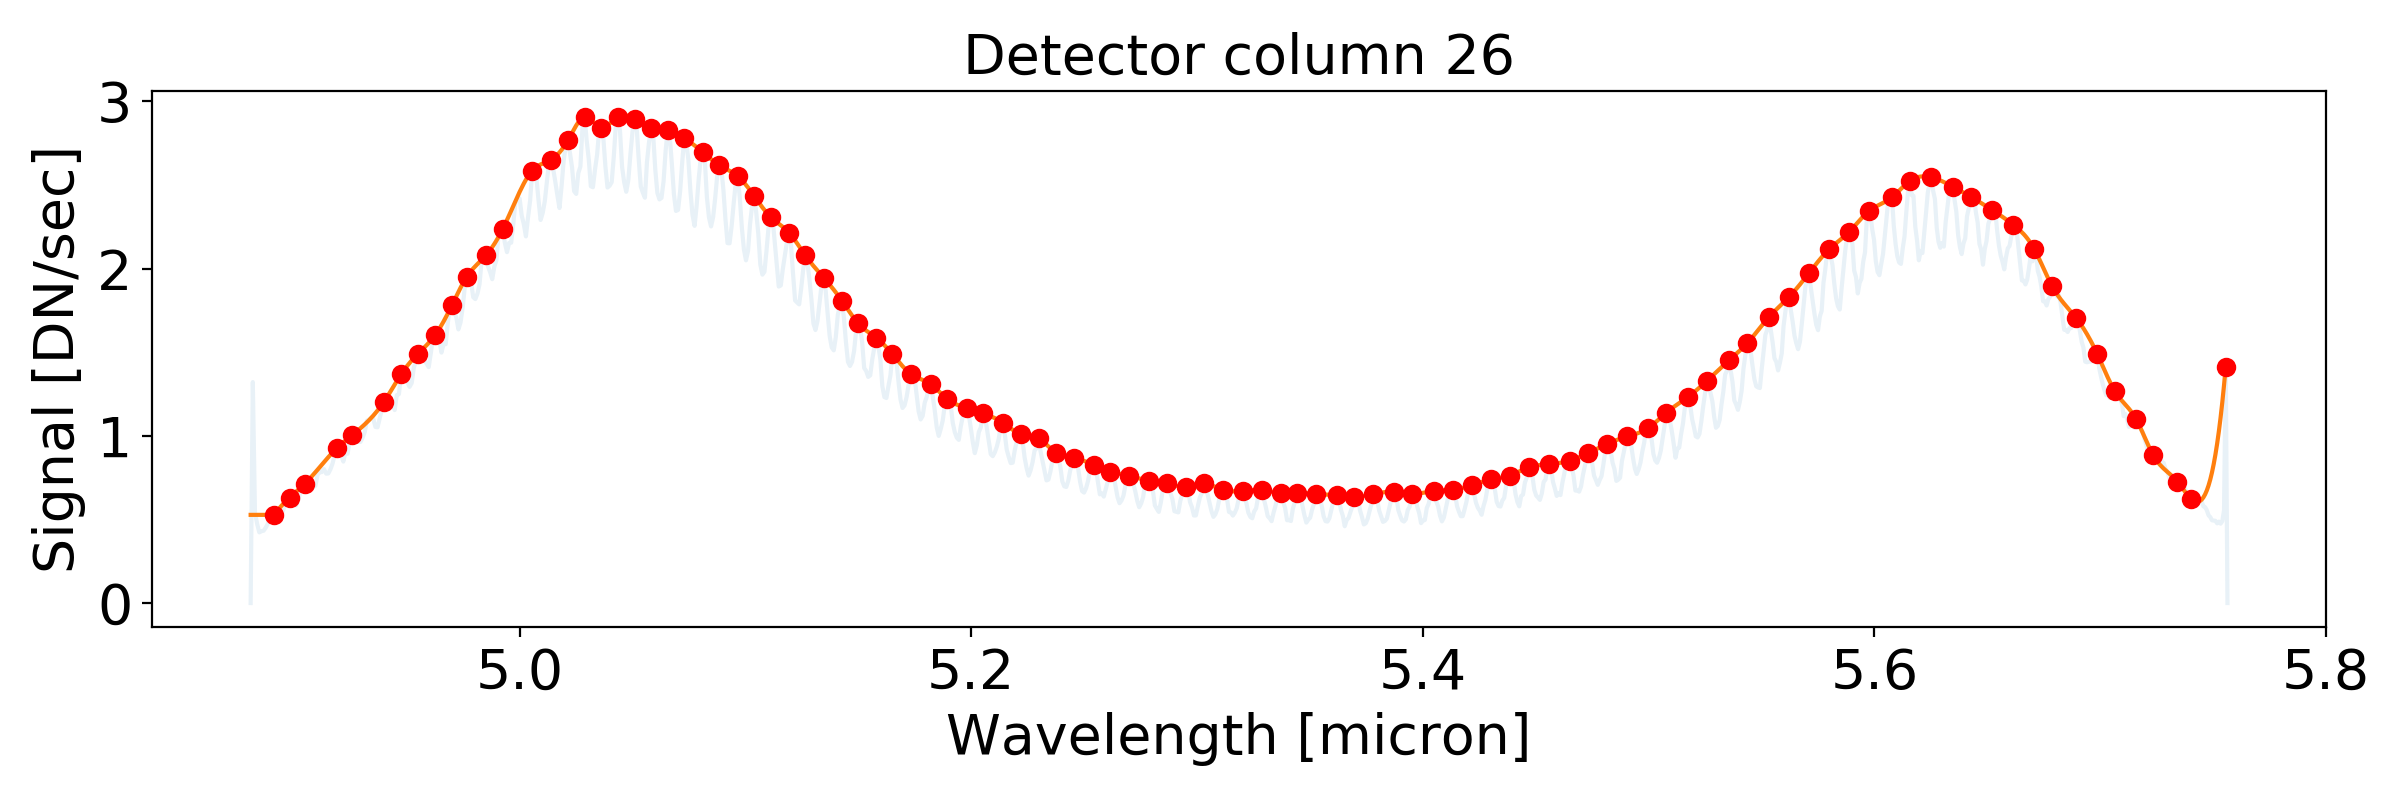

<IPython.core.display.Javascript object>


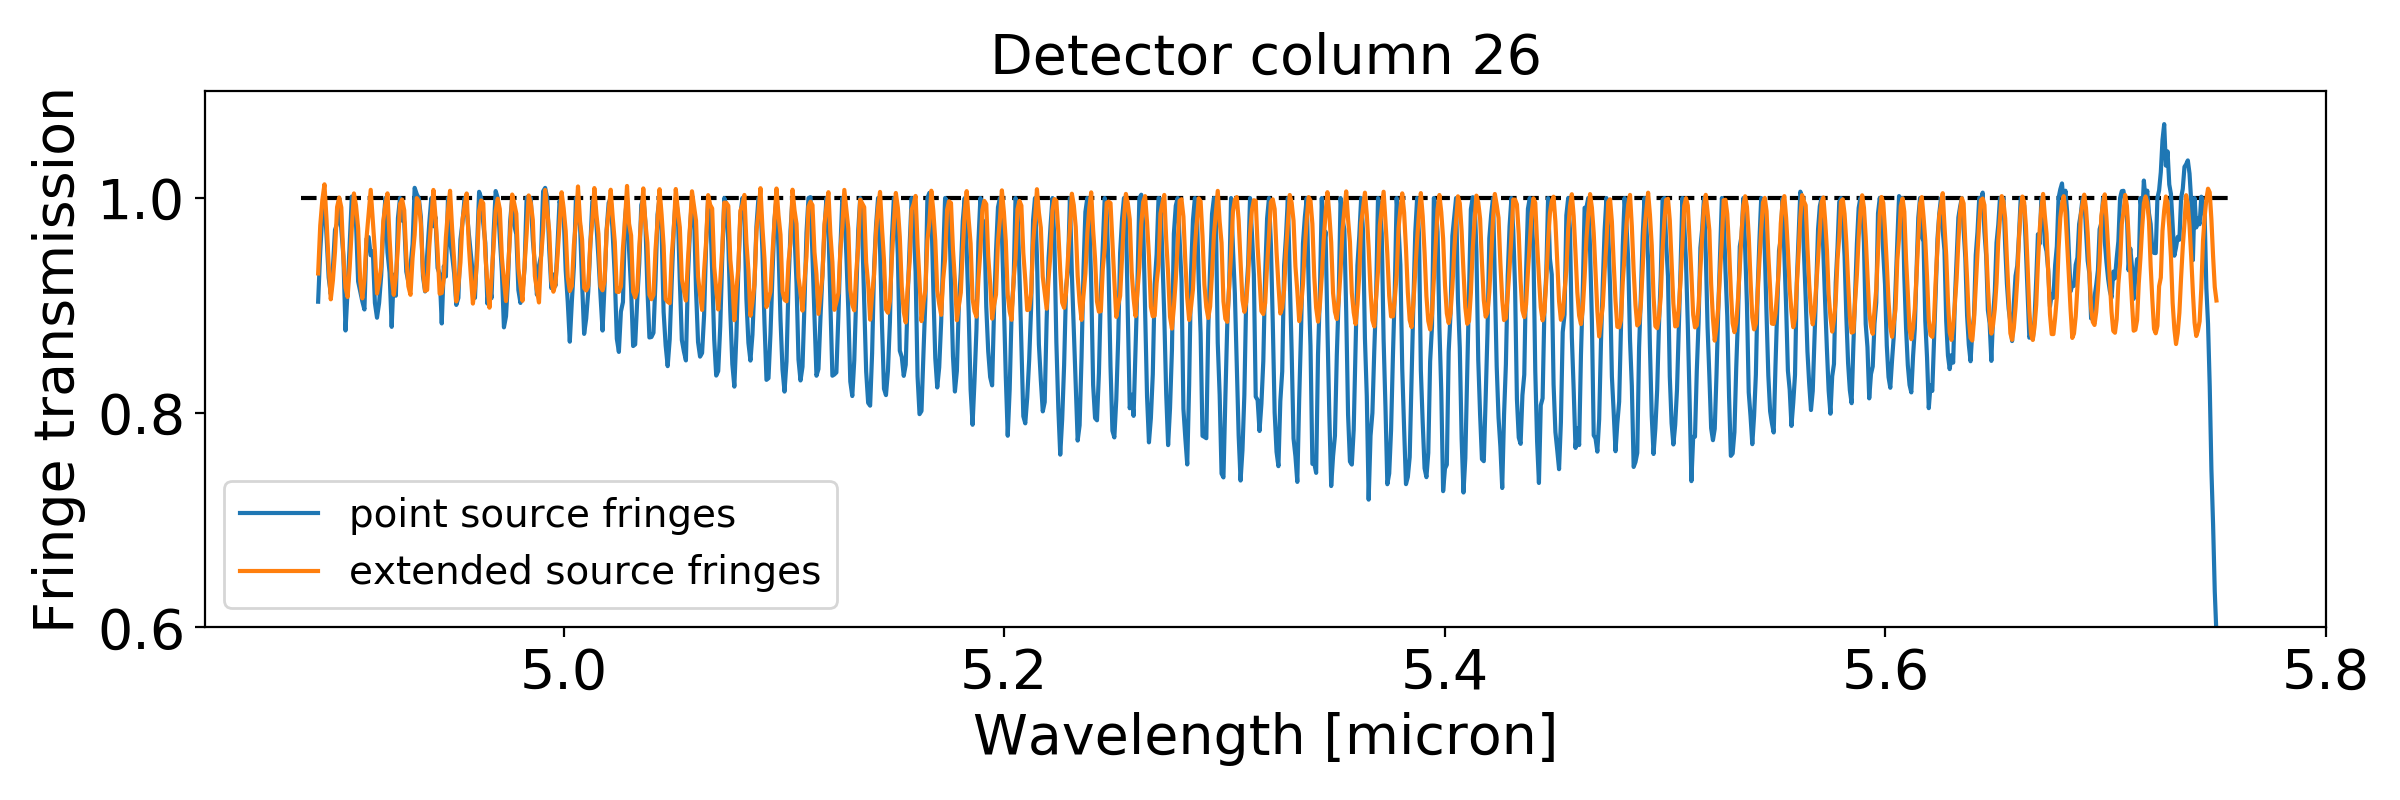

In [15]:
# quick example of fringe correction
xcol = 26
example_spectrum = sci_exp_slope_SW[:,xcol]
example_spectrum_norm = funcs.norm_fringe(example_spectrum,min_dist=6)

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],example_spectrum_norm[0],alpha=0.1)
plt.plot(lambdaMap[:,xcol],example_spectrum_norm[2])
plt.plot(lambdaMap[:,xcol][example_spectrum_norm[1]],example_spectrum_norm[0][example_spectrum_norm[1]],'ro')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol][8:-8],(example_spectrum_norm[0]/example_spectrum_norm[2])[8:-8],label='point source fringes')
plt.plot(lambdaMap[:,xcol][8:-8],fringe_img[:,xcol][8:-8],label='extended source fringes')
plt.hlines(1,lambdaMap[:,xcol][0],lambdaMap[:,xcol][-1],'k',linestyle='dashed')
plt.ylim(0.6,1.1)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Fringe transmission')
plt.legend(loc='lower left')
plt.tight_layout()

**Apply spectrophotometric correction**

<IPython.core.display.Javascript object>


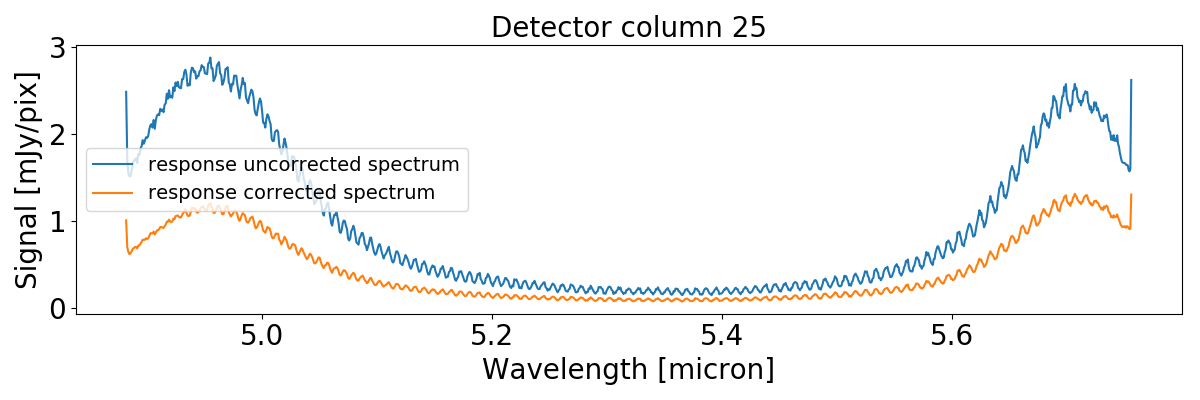

<IPython.core.display.Javascript object>


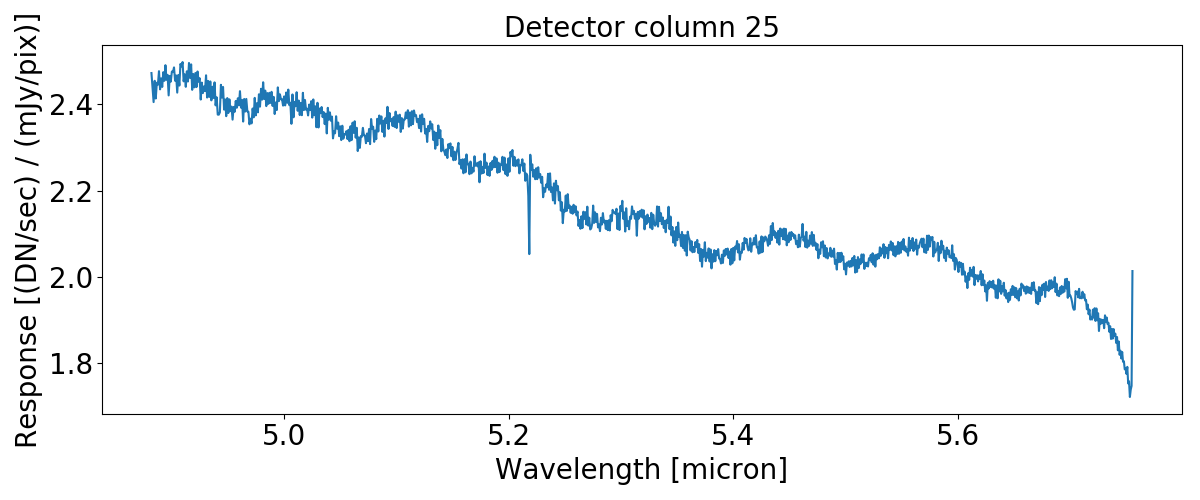

In [18]:
photom_img = funcs.get_cdps('1A',cdpDir)[1]
sci_exp_slope_photomCorr = sci_exp_slope_fringeCorr/photom_img

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope_fringeCorr[:,xcol],label='response uncorrected spectrum')
plt.plot(lambdaMap[:,xcol],sci_exp_slope_photomCorr[:,xcol],label='response corrected spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [mJy/pix]')
plt.legend(loc='center left')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],photom_img[:,xcol])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Response [(DN/sec) / (mJy/pix)]')
plt.tight_layout()

**Detector spectral binning**

<IPython.core.display.Javascript object>


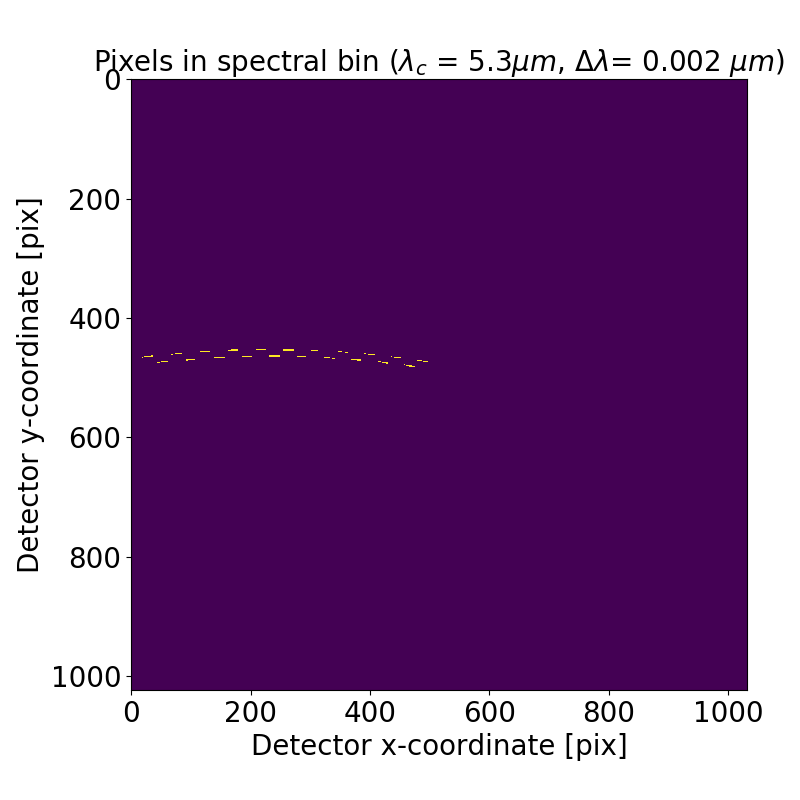

In [19]:
specres_table = funcs.get_cdps('1A',cdpDir)[4]
lambcens,lambfwhms = funcs.spectral_gridding('1A',d2cMaps,specres_table=specres_table)

ibin = int(len(lambcens)/2) +1
selectedpixelMap = np.zeros((1024,1032))
selectedpixelMap[(abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)] = 1.

plt.figure(figsize=(8,8))
plt.imshow(selectedpixelMap,interpolation='None',aspect='equal')
plt.title(r'Pixels in spectral bin ($\lambda_c$ = {}$\mu m$, $\Delta\lambda$= {} $\mu m$)'.format(round(lambcens[ibin],1),round(lambfwhms[ibin],3)))
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Detector y-coordinate [pix]')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

**Point source centroiding**

In [20]:
sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding('1A',sci_exp_slope_photomCorr,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='2D')

source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])

STEP 1: Rough centroiding
Slice 12 has the largest summed flux
Source position: beta = 0.18arcsec, alpha = -0.18arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 39, 40, 41, 43, 121, 122, 123, 130, 131, 197, 203, 295, 296, 304, 305, 306, 345, 346, 347, 348, 371, 372, 373, 374, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]


<IPython.core.display.Javascript object>


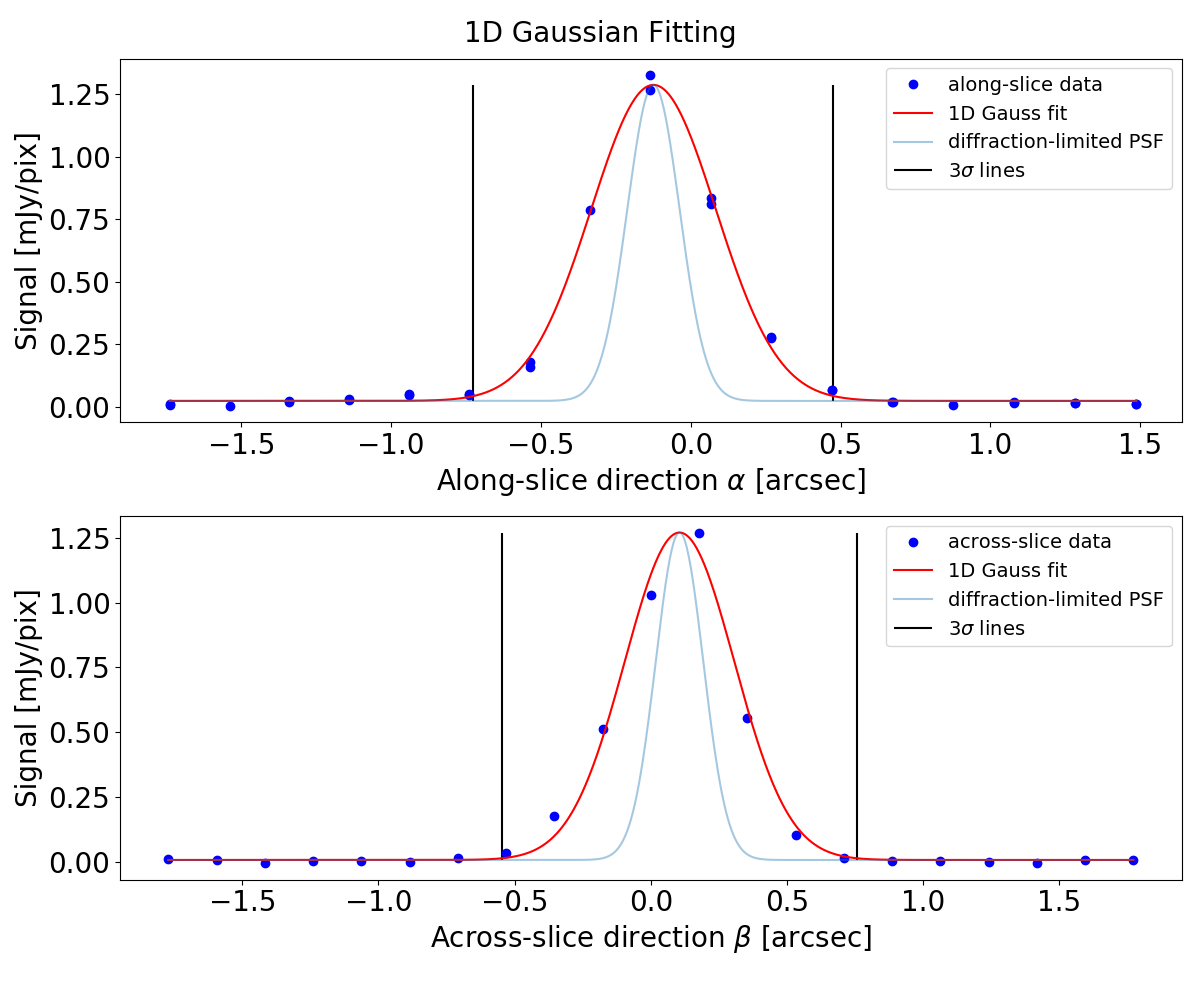

<IPython.core.display.Javascript object>


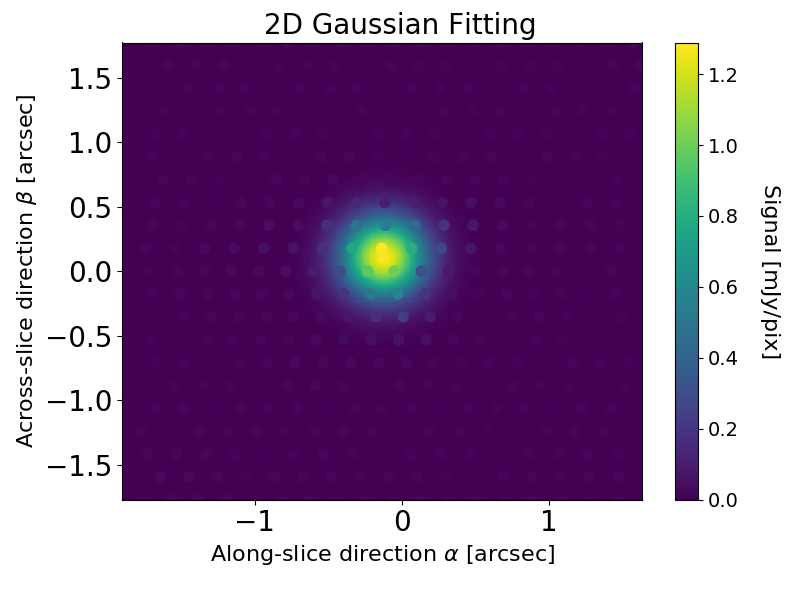

<IPython.core.display.Javascript object>


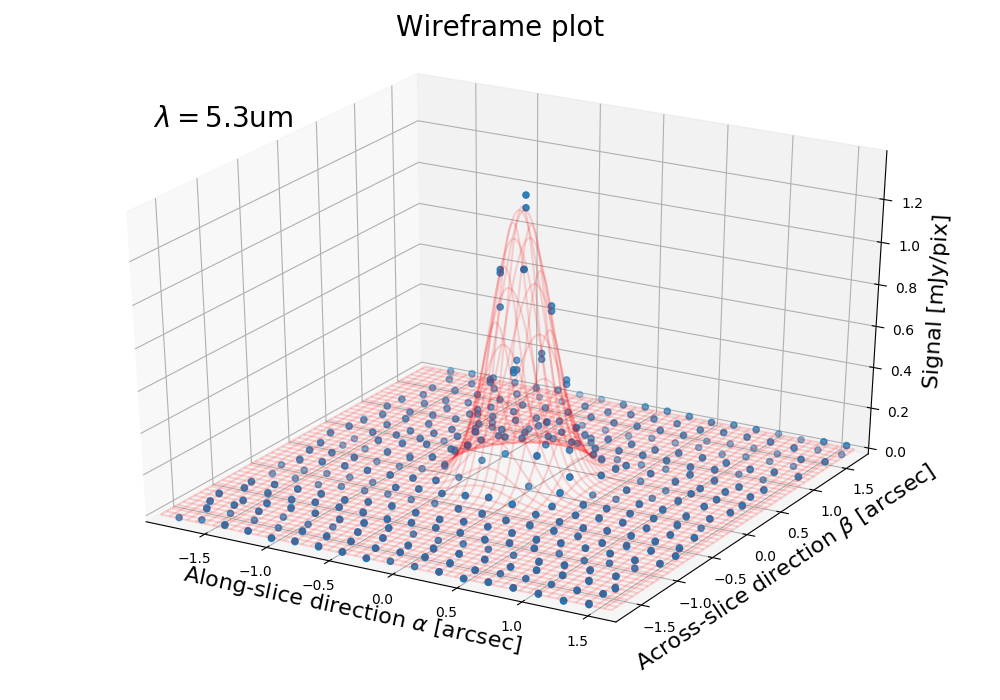

In [27]:
funcs.plot_point_source_centroiding('1A',sci_exp_slope_photomCorr,d2cMaps,spec_grid=[lambcens,lambfwhms],centroid=[sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp],ibin=300,data='divphotom')

**Perform aperture photometry**

In [22]:
# define aperture shape
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
if (np.isnan(source_alpha_center)) or (np.isnan(source_beta_center) is True):
    raise 'Invalid centroid! Center is NaN!'
ellipse = ((source_alpha_center, source_beta_center),(1,1),0)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(1.)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# save final output as the aperture and calculate the aperture area
aperture = ellr
aperture_area = aperture.area

In [23]:
# create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

Pixel weight mapping
0/599 bins processed
100/599 bins processed
200/599 bins processed
300/599 bins processed
400/599 bins processed
500/599 bins processed
599/599 bins processed


In [25]:
# perform 1d aperture extraction
aperture_extracted_signal = funcs.aperture_weighted_photometry_point_source(sci_exp_slope_photomCorr,weight_map,d2cMaps,spec_grid=[lambcens,lambfwhms])

<IPython.core.display.Javascript object>


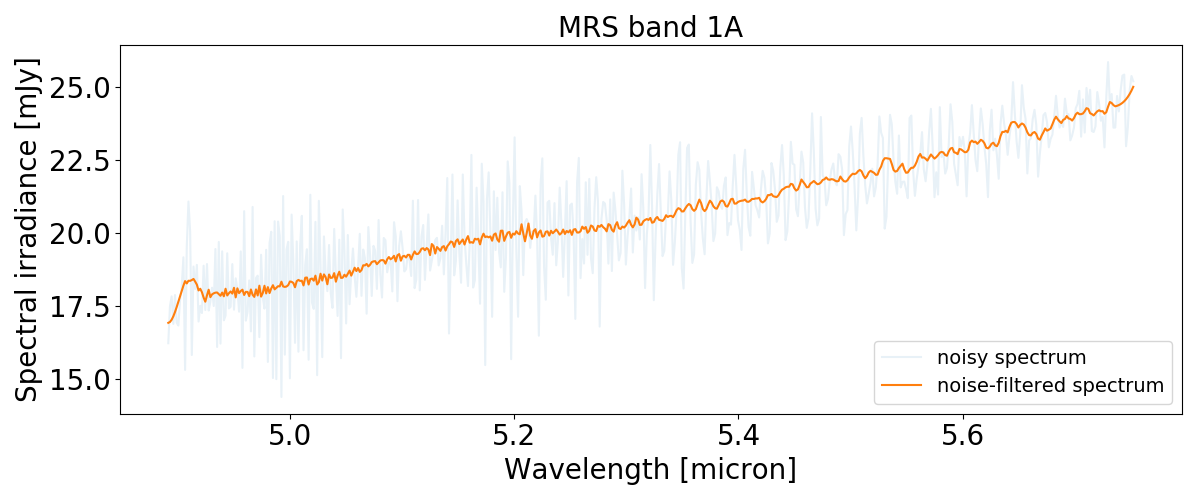

In [26]:
# plot extracted spectrum
plt.figure(figsize=(12,5))
plt.plot(lambcens[30:-15],aperture_extracted_signal[30:-15],alpha=0.1,label='noisy spectrum')
plt.plot(lambcens[30:-15],savgol_filter(aperture_extracted_signal[30:-15],21,3),label='noise-filtered spectrum')
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.title('MRS band {}'.format('1A'),fontsize=20)
plt.legend(loc='lower right')
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()